In [1]:
import os
import librosa
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_LIST = []
SAMPLE_RATES = []
LABLES = []
FEATURES = []
MFCCS = []

# Configuration
SAMPLE_RATE = 8000  # Already set
FIXED_LENGTH = 0.7  # Target duration (1 sec)

N_MELS = 256     # Number of Mel bands
N_FFT = 2048     # FFT window size
HOP_LENGTH = 64  # Step size for STFT

# Paths (Set your dataset path)
DATASET_PATH = "free-spoken-digit\\dev"
SAVE_FEATURES_PATH = "processed_features.npy"

## Load Dataset

In [3]:
DATASET_PATH = 'free-spoken-digit'

os.listdir(DATASET_PATH)
wav_files = [f for f in os.listdir(DATASET_PATH) if f.endswith('.wav')]

f"Found {len(wav_files)} .wav files."

'Found 3990 .wav files.'

In [4]:
def load_wav_file(filepath):
    sample_rate, data = wavfile.read(filepath)
    return sample_rate, data


In [5]:
def drawHistogram(data:np.array):
    
    # Plotting the waveform
    plt.figure(figsize=(14, 6))
    plt.plot(data, label="Audio Signal", )
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.title("Waveform of Audio Signal")
    plt.legend()
    plt.grid(True)
    plt.savefig("img\\Waveform_of_Audio_Signal.jpg")
    plt.show()

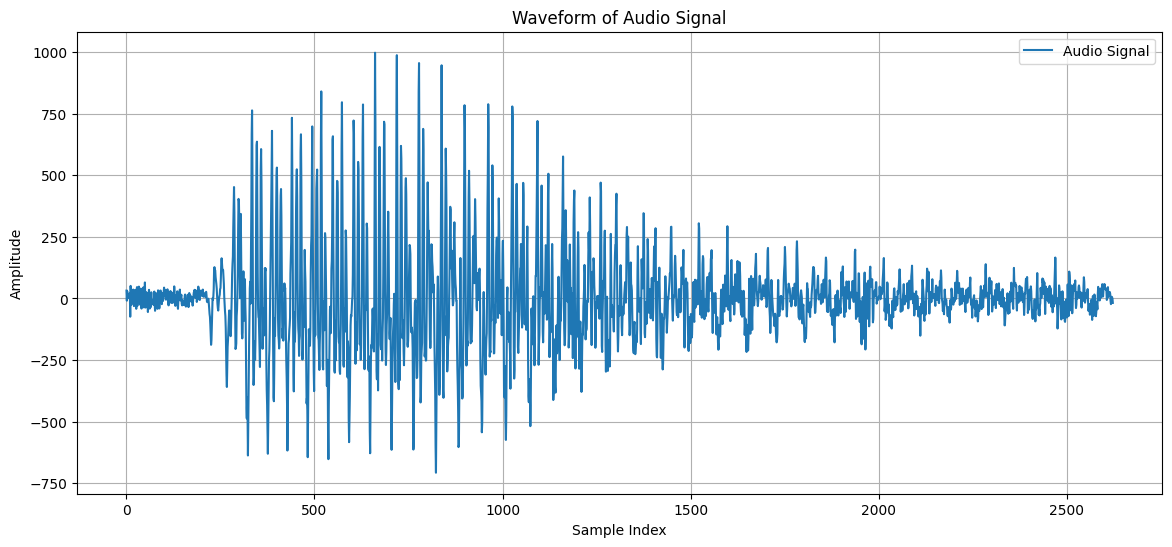

In [6]:
_, data = load_wav_file(DATASET_PATH + "\\" +wav_files[90])


drawHistogram(data)


# PREPROCESSING

##### LOAD `.WAV` FILES

In [7]:
os.listdir(DATASET_PATH)
wav_files = [f for f in os.listdir(DATASET_PATH) if f.endswith('.wav')]

f"Found {len(wav_files)} .wav files."


for file in wav_files:
    filepath = os.path.join(DATASET_PATH, file)
    sample_rate, data = load_wav_file(filepath)
    
    # Convert stereo to mono if necessary
    if len(data.shape) > 1:
        data = np.mean(data, axis=1)

    DATA_LIST.append(data.astype(float))
    SAMPLE_RATES.append(sample_rate)
    label = int(file.split("_")[1].split(".")[0])
    LABLES.append(label)
    


- ***Check the size of dataset***
- ***Get the unique values of sample_rate***

In [8]:
len(DATA_LIST), set(SAMPLE_RATES)

(3990, {8000})

##### Get duration

In [9]:

durations = []

for filename in os.listdir(DATASET_PATH):
    if filename.endswith(".wav"):
        file_path = os.path.join(DATASET_PATH, filename)
        y, sr = librosa.load(file_path, sr=None)  
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)
      

# Get max and min duration
max_duration = max(durations)
min_duration = min(durations)
max_duration, min_duration, np.array(durations).mean()


(2.28275, 0.1435, 0.4224512844611529)

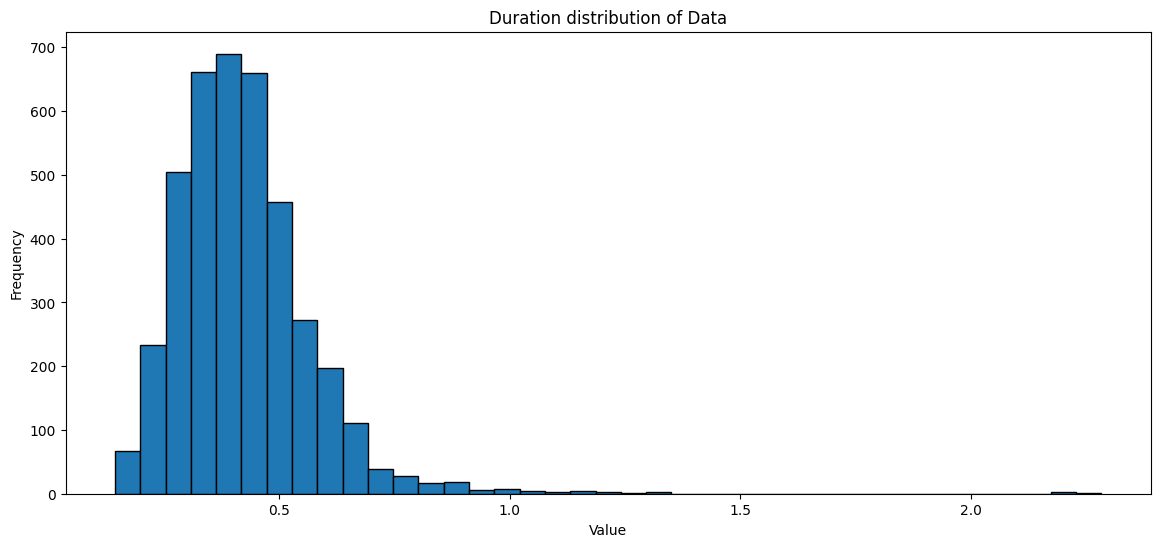

In [10]:
plt.figure(figsize=(14, 6))
plt.hist(np.array(durations), edgecolor='black', bins=int(len(durations)/100))  # `bins` determines the number of bars
plt.title("Duration distribution of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig("img\\Duration_distribution_of_Data.jpg")
plt.show()

In [11]:
durations = np.array(durations)
FIXED_LENGTH = durations.mean() + durations.std()

### The statistical describtions of dataset

In [12]:
max_len = -1
min_len = 18000


len_array = np.zeros(shape=(len(DATA_LIST),))  # Create a 1D array of appropriate size
freq_array = np.zeros(shape=(len(DATA_LIST),))  # Create a 1D array of appropriate size
dtypes_list = []

for i in range(len(DATA_LIST)):
    sample_length = DATA_LIST[i].shape[0]  # Length of the waveform
    dtypes_list.append(DATA_LIST[i].dtype)
    
    if max_len < sample_length:
        max_len = sample_length

    if min_len > sample_length:
        min_len = sample_length

    len_array[i] = sample_length  # Store length in the array

print("Max Length:", max_len, "\nMin Length:", min_len, "\nAVG Length:",len_array.mean(), "\nSTD Length:", len_array.std())


Max Length: 18262 
Min Length: 1148 
AVG Length: 3379.6102756892233 
STD Length: 1176.721618379887


### Equaling the length of `.wav` files

In [13]:

def pad_or_truncate(audio_array, sample_rate=SAMPLE_RATE, fixed_length=FIXED_LENGTH):

    target_length = int(fixed_length * sample_rate)
    
    if len(audio_array) < target_length:
        audio_array = np.pad(audio_array, (0, target_length - len(audio_array)))  # Pad
    else:
        audio_array = audio_array[:target_length]  # Truncate

    return audio_array



for i in range(len(DATA_LIST)):
    MFCCS.append(pad_or_truncate(audio_array=DATA_LIST[i], sample_rate=SAMPLE_RATES[i]))
    


In [14]:
MFCCS = np.array(MFCCS)
MFCCS.shape

(3990, 4556)

### Feature Extraction / Normalization
- ***SPECTROGRAMS***
- ***Min-max Scaler***

In [15]:

def audio_to_mel_spectrogram(audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """Convert raw audio waveform into Mel-Spectrogram."""
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert power spectrogram to dB scale
    return mel_spec_db

def normalize_spectrogram(spectrogram):
    """Normalize spectrogram to range [0, 1]."""
    return (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())




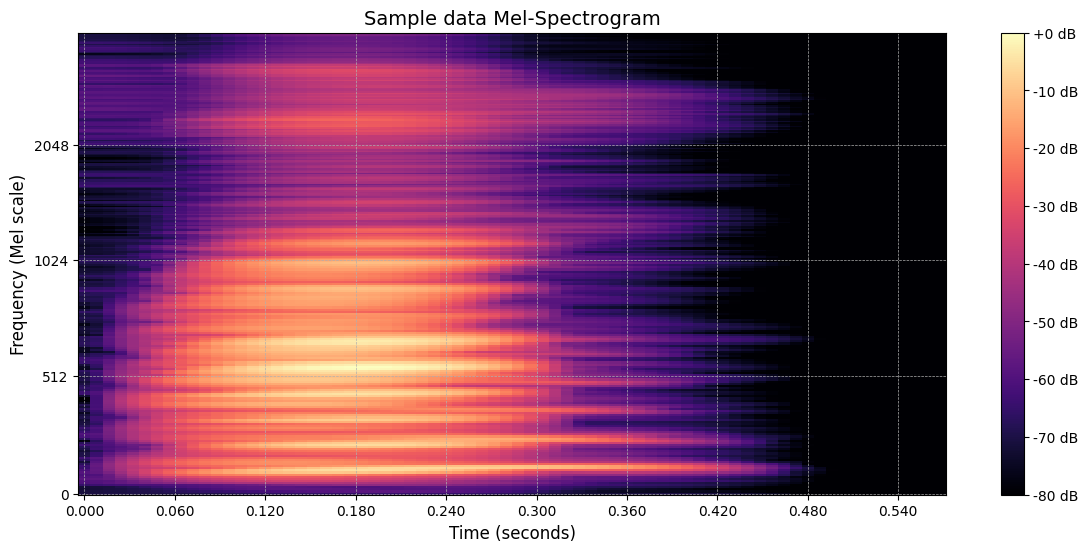

In [16]:
# Example usage with one sample
example_audio =  MFCCS[900]

mel_spec = audio_to_mel_spectrogram(example_audio)

mel_spec_norm = normalize_spectrogram(mel_spec)

# Plot the Mel-Spectrogram
plt.figure(figsize=(14, 6))
librosa.display.specshow(mel_spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Sample data Mel-Spectrogram", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Frequency (Mel scale)", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.savefig("img\\Sample_data_Mel_Spectrogram.jpg")
plt.show()

In [ ]:

SPECTROGRAMS = []


for i, audio in enumerate(MFCCS):
    mel_spec = audio_to_mel_spectrogram(audio)
    mel_spec_norm = normalize_spectrogram(mel_spec)

    SPECTROGRAMS.append(mel_spec_norm)

# Convert to NumPy array
SPECTROGRAMS = np.array(SPECTROGRAMS)  # Shape: (1500, 64, T) where T depends on hop_length

In [18]:
np.save(SAVE_FEATURES_PATH, SPECTROGRAMS)
SPECTROGRAMS.shape

(3990, 256, 72)

### Defining The Model

In [19]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [20]:

# Reshape to include a single channel (for grayscale CNN input)
spectrograms = SPECTROGRAMS[..., np.newaxis]  # Shape: (1500, 256, 256, 1)

# One-hot encode labels
num_classes = len(set(LABLES))  # Should be 10 for digits 0-9
labels = to_categorical(LABLES, num_classes)  # Shape: (1500, 10)
spectrograms.shape

(3990, 256, 72, 1)

#### Splite the dataset

In [21]:

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [22]:

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 72, 1)),  # 1st Conv Layer
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),  # 2nd Conv Layer
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),  # 3rd Conv Layer
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),  # Flatten before feeding to Dense layers
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Prevent overfitting

    Dense(10, activation='softmax')  # Output layer (10 classes for digits 0-9)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 70, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 254, 70, 32)       128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 35, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 33, 64)       18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 33, 64)       256       
 chNormalization)                                                
                                                        

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stop])

Epoch 1/50
70/70 [==============================] - 39s 536ms/step - loss: 4.3144 - accuracy: 0.4355 - val_loss: 21.6254 - val_accuracy: 0.1003
Epoch 2/50
70/70 [==============================] - 35s 497ms/step - loss: 1.5483 - accuracy: 0.5698 - val_loss: 30.1438 - val_accuracy: 0.1153
Epoch 3/50
70/70 [==============================] - 31s 444ms/step - loss: 1.2726 - accuracy: 0.6150 - val_loss: 20.4937 - val_accuracy: 0.1429
Epoch 4/50
70/70 [==============================] - 31s 438ms/step - loss: 1.1466 - accuracy: 0.6535 - val_loss: 36.2404 - val_accuracy: 0.1090
Epoch 5/50
70/70 [==============================] - 30s 433ms/step - loss: 1.1494 - accuracy: 0.6799 - val_loss: 12.6319 - val_accuracy: 0.2669
Epoch 6/50
70/70 [==============================] - 27s 392ms/step - loss: 0.8558 - accuracy: 0.7122 - val_loss: 10.0615 - val_accuracy: 0.2531
Epoch 7/50
70/70 [==============================] - 27s 391ms/step - loss: 0.6072 - accuracy: 0.7820 - val_loss: 6.6211 - val_accuracy: 

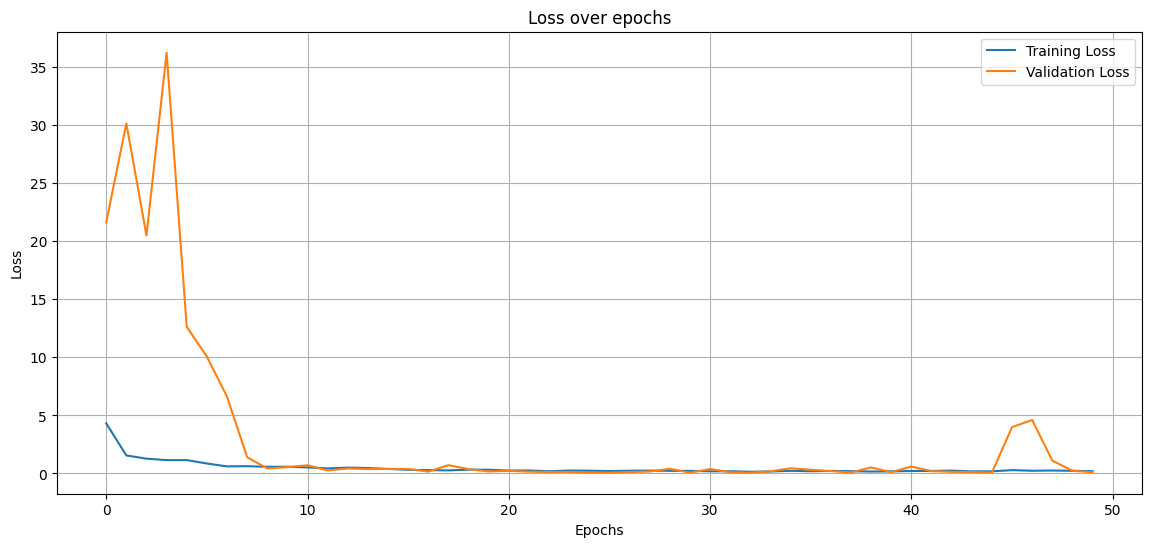

In [24]:
# Plot loss
plt.figure(figsize=(14,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.grid()
plt.savefig("img\Loss_over_epochs.jpg")
plt.show()

In [25]:
model.save("cnn_speech_digit_classifier.h5")
print("Model saved successfully!")

Model saved successfully!


c:\Users\taha_kms\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluate the prediction

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np

# Get predictions
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # Get the class with highest probability
y_true_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test to labels

# Print classification report
print(classification_report(y_true_labels, y_pred_labels))


25/25 [==============================] - 3s 99ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.99      0.98      0.98        86
           2       0.97      0.99      0.98        78
           3       1.00      0.98      0.99        85
           4       1.00      0.97      0.99        78
           5       0.99      1.00      0.99        74
           6       1.00      1.00      1.00        87
           7       0.98      1.00      0.99        80
           8       1.00      1.00      1.00        76
           9       0.98      0.99      0.98        83

    accuracy                           0.99       798
   macro avg       0.99      0.99      0.99       798
weighted avg       0.99      0.99      0.99       798



In [27]:
# Get predicted and true labels
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true_labels = np.argmax(y_test, axis=1)  # Convert one-hot true labels to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Define class labels (digits 0-9)
class_labels = [str(i) for i in range(10)]

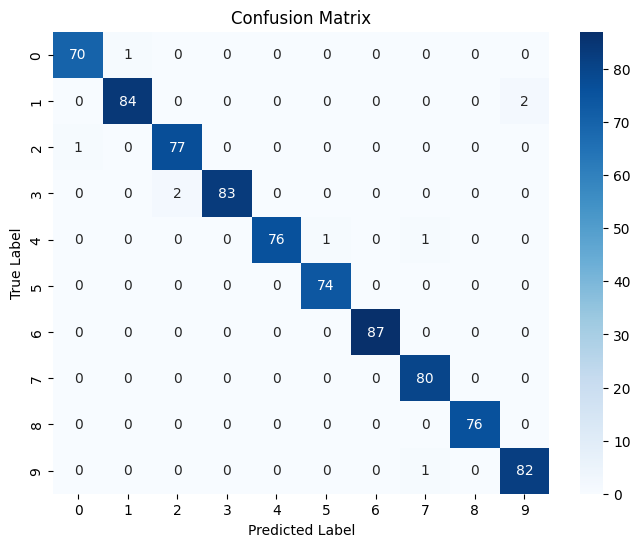

In [28]:
# Create a heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("img\Confusion_Matrix.jpg")
# Show the plot
plt.show()
